In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from utils import preprocessing, plotting
sns.set(style='darkgrid')
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn.model_selection import cross_validate, cross_val_predict


In [27]:
# data loading
questions = pd.read_csv('data/question_data.csv', sep=';')
questions = questions.set_index('Unnamed: 0')  # set first column (question number) as index
questions.index = questions.index.rename('q_id')

In [28]:
data = pd.read_parquet('data/train.parquet')
political_belief = 'q212813'
data.rename({'q212813': 'political_belief'}, axis=1, inplace=True)
data.rename({'Unnamed: 0': 'user_id'}, axis=1, inplace=True)

# Top K descriptive questions df

In [45]:
descriptive_questions = [column for column in data.columns if column.startswith('q')]
display(questions.loc[descriptive_questions].head())

,text,option_1,option_2,option_3,option_4,N,Type,Order,Keywords
q_id,,,,,,,,,
q49,Which word describes you better?,Carefree,Intense,NaN,NaN,49827,N,NaN,descriptive
q50,Have you ever seen a therapist?,Yes,No,NaN,NaN,9507,O,NaN,descriptive
q60,Which describes you better?,Warm-hearted,Cool-headed,NaN,NaN,21205,O,NaN,descriptive
q61,Are you a better conversationalist or listener?,Conversationalist,Listener,NaN,NaN,3174,O,NaN,descriptive
q63,Which word describes you better?,Private,Social,NaN,NaN,23765,O,NaN,descriptive


In [46]:
# per question count number of times the question is answered
n_answers_per_question = data[descriptive_questions].count(axis=0)
sorted_questions = n_answers_per_question.sort_values(ascending=False).index
question_data = questions.join(n_answers_per_question.to_frame('n_answers')) 
display(questions.loc[sorted_questions[:10]][['text']])

,text
q85419,Which type of wine would you prefer to drink o...
q416235,Do you like watching foreign movies with subti...
q358084,Do you enjoy intense intellectual conversations?
q501,Have you smoked a cigarette in the last 6 months?
q77,How frequently do you drink alcohol?
q20930,Rate your self-confidence:
q29829,How often do you keep your promises?
q35660,How often are you open with your feelings?
q80,What's your deal with harder drugs (stuff beyo...
q4018,Are you happy with your life?


In [47]:
subset_df = data[descriptive_questions+['gender']+['d_age']]
print(subset_df.shape)

(36085, 831)


In [48]:
K=200
subset_size_topk = [subset_df.loc[:, sorted_questions[:k]].dropna().shape[0] for k in range(1, K)]

In [50]:
# biggest k with >=cutoff subjects who answered ALL k questions
cutoff = 15000
n_most_answered = next(x[0] for x in enumerate(subset_size_topk) if x[1] < cutoff)
n_most_answered

26

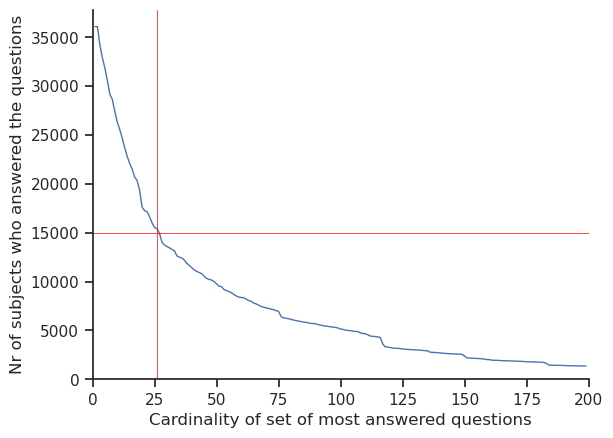

In [51]:
sns.set_style("white")
sns.set_style("ticks")
g = sns.lineplot(x = range(1,K), y = subset_size_topk, linewidth=1)
g.axhline(y=cutoff, color='red', linewidth=0.5)
g.axvline(x=n_most_answered, color='red', linewidth=0.5)

plt.xlim(0, 200)
plt.ylim(0)
sns.despine()
#plt.ylim(0,len(features_df))
g.set(xlabel ="Cardinality of set of most answered questions", ylabel = "Nr of subjects who answered the questions")
#title ='Nr of subjects who answered the same k most anwered questions '
#plt.figtext(0.5, -0.1, 'Grouping most answered questions into a set, comparing the number of questions in the set to the number of subjects who answered all questions in the set', wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

# Stratification

In [59]:
top_questions = sorted_questions[:n_most_answered].to_list()
filter_by = top_questions + ['political_belief', 'gender', 'd_age']
stratified_df = data[filter_by].dropna()
n_conservative = stratified_df.groupby('political_belief').count().iloc[1, 0]
stratified_df = stratified_df.groupby('political_belief', group_keys=False).apply(lambda x: x.sample(n=n_conservative, random_state=1))
display(stratified_df)


,q85419,q416235,q358084,q501,q77,q20930,q29829,q35660,q80,q4018,...,q416236,q442,q40441,q53611,q19874,q1062,q158,political_belief,gender,d_age
index,,,,,,,,,,,,,,,,,,,,,
52174,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Yes,No,Sometimes,Average,Always,Usually,"I've done drugs in the past, but no longer.",Yes,...,Yay!,Good,Maybe a little bit.,Rarely.,0-6 months,At least once a day.,No,Centrist,Woman,26.0
62454,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Yes,No,Rarely,Average,Whenever possible,Usually,I never do drugs.,Yes,...,Okay,Bad,No.,Never.,12+ months,Usually daily. I skip some.,Yes,Centrist,Man,43.0
60035,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Yes,No,Rarely,Average,Whenever possible,Usually,"I've done drugs in the past, but no longer.",Yes,...,Okay,Bad,Maybe a little bit.,Never.,0-6 months,At least once a day.,No,Centrist,Man,42.0
33328,I don't drink wine.,Yes,Yes,No,Never,Higher than average,Always,Usually,I never do drugs.,Yes,...,Yay!,Bad,No.,Never.,I've never been in a relationship,At least once a day.,No,Centrist,Man,21.0
24039,"White (such as Chardonnay, Riesling).",Yes,Yes,No,Sometimes,Average,Whenever possible,Usually,I never do drugs.,Yes,...,Okay,Bad,Maybe a little bit.,Never.,12+ months,At least once a day.,No,Centrist,Woman,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31681,"Red (such as Merlot, Cabernet, Shiraz).",Can't answer without a subtitle,Yes,No,Sometimes,Average,Whenever possible,Rarely,I never do drugs.,No,...,Yay!,Good,Maybe a little bit.,Rarely.,0-6 months,Usually daily. I skip some.,Yes,Other,Man,26.0
54047,"Red (such as Merlot, Cabernet, Shiraz).",Yes,Yes,Yes,Sometimes,Average,Whenever possible,Usually,"I've done drugs in the past, but no longer.",Yes,...,Yay!,Good,Maybe a little bit.,Rarely.,12+ months,At least once a day.,No,Other,Man,44.0
61910,"Red (such as Merlot, Cabernet, Shiraz).",Yes,Yes,Yes,Sometimes,Higher than average,Whenever possible,Usually,I never do drugs.,Yes,...,Okay,Bad,Yes.,Frequently.,6-12 months,Usually daily. I skip some.,Yes,Other,Man,43.0


# Question distribution

/opt/conda/envs/data_literacy/lib/python3.10/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


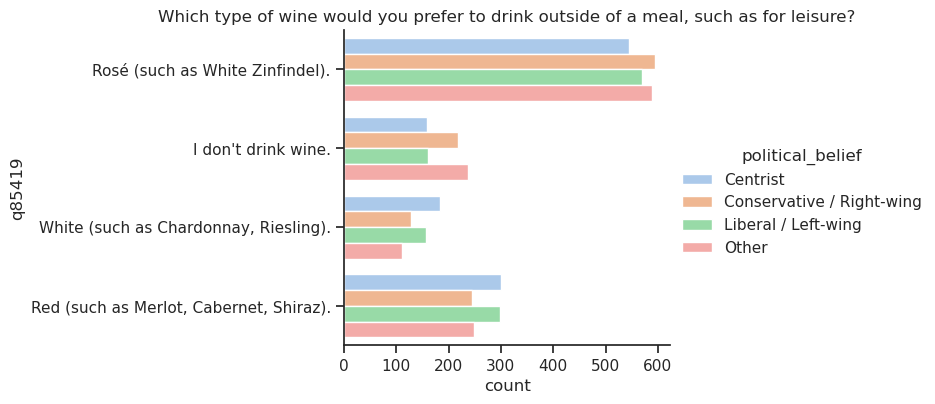

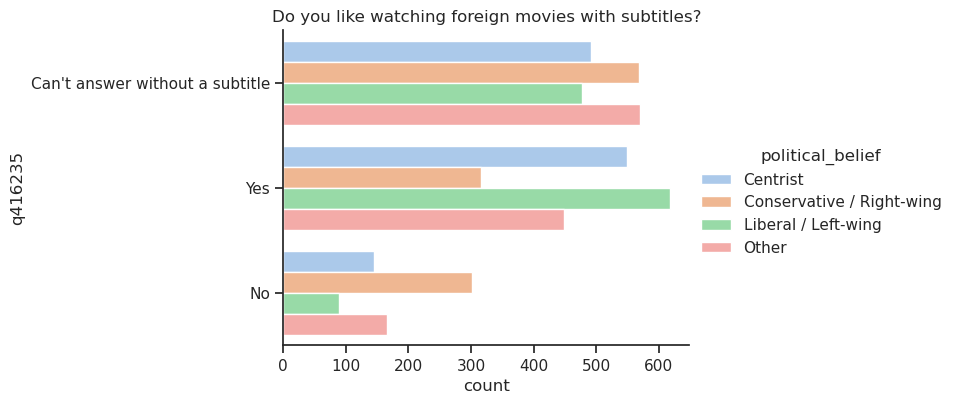

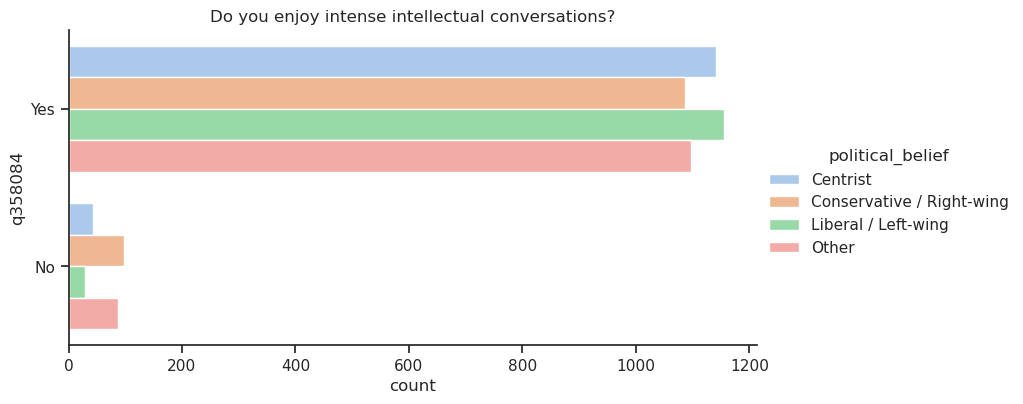

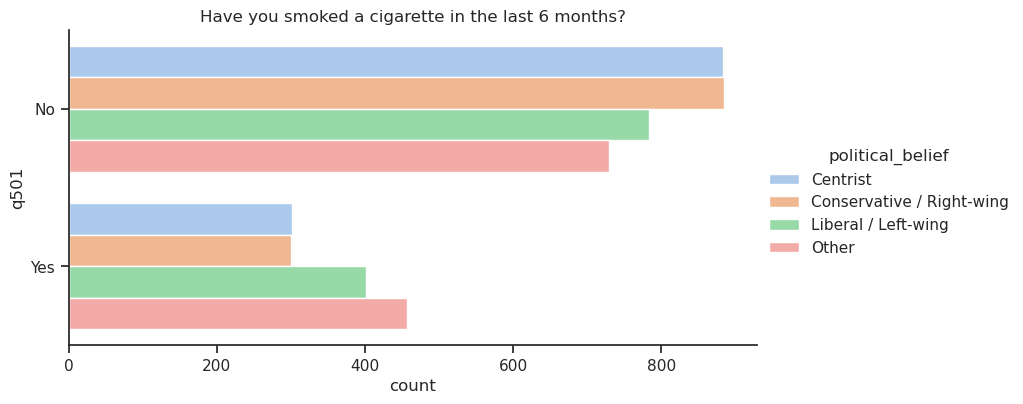

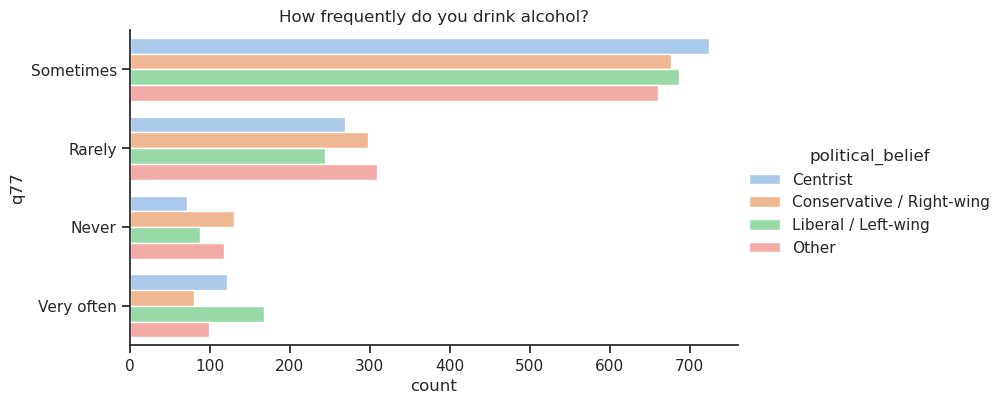

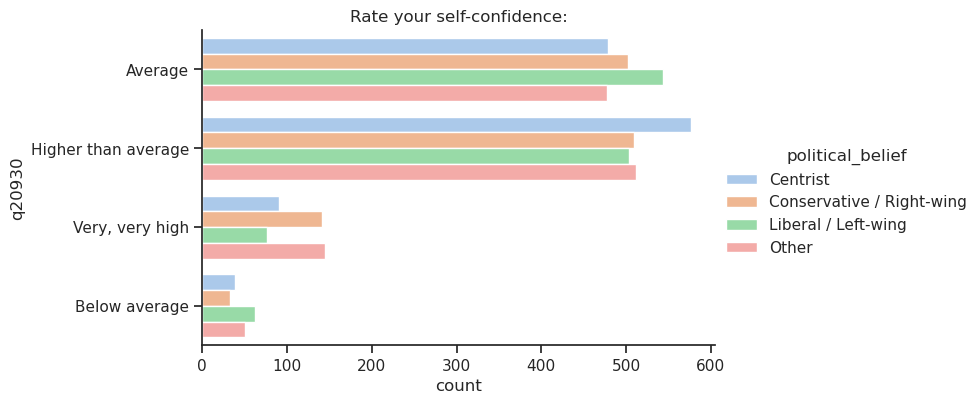

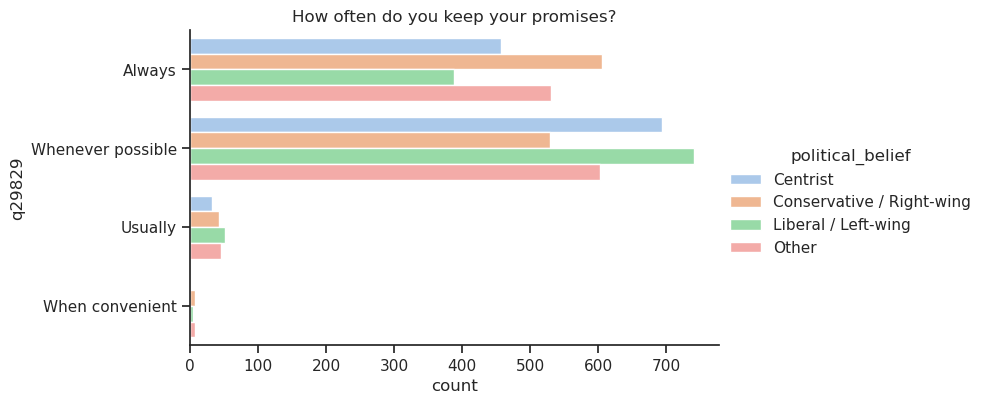

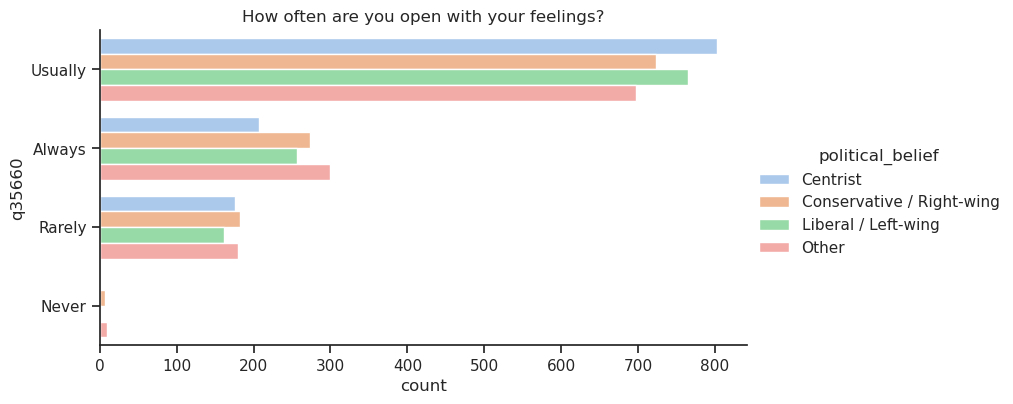

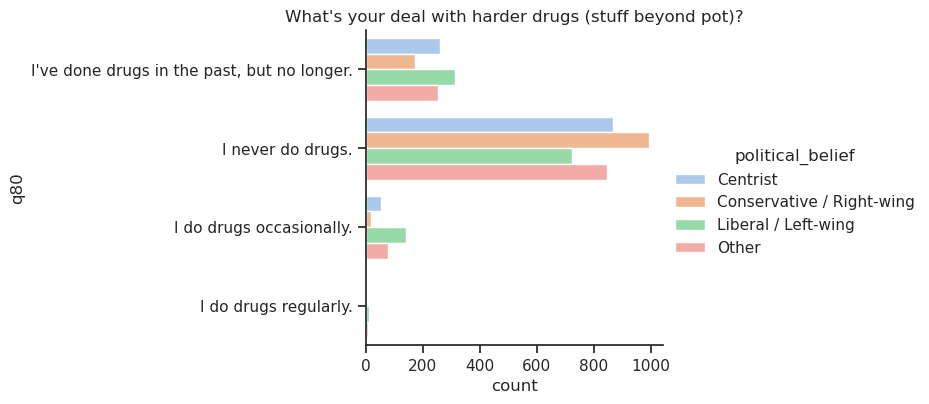

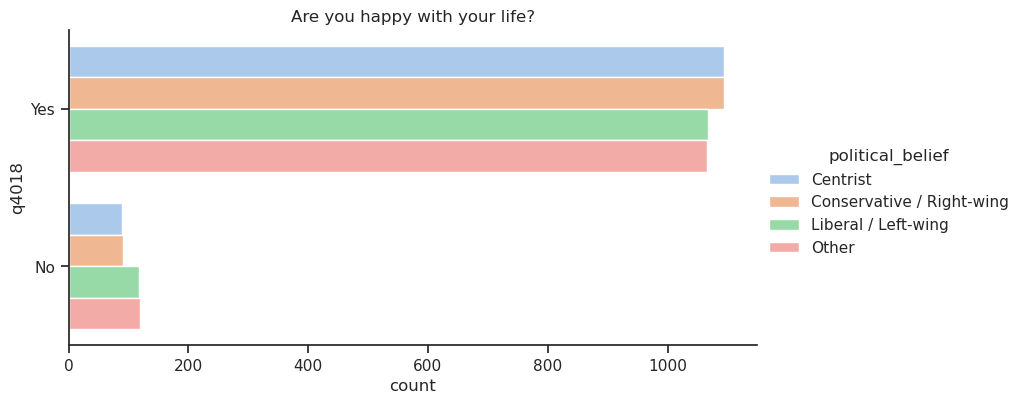

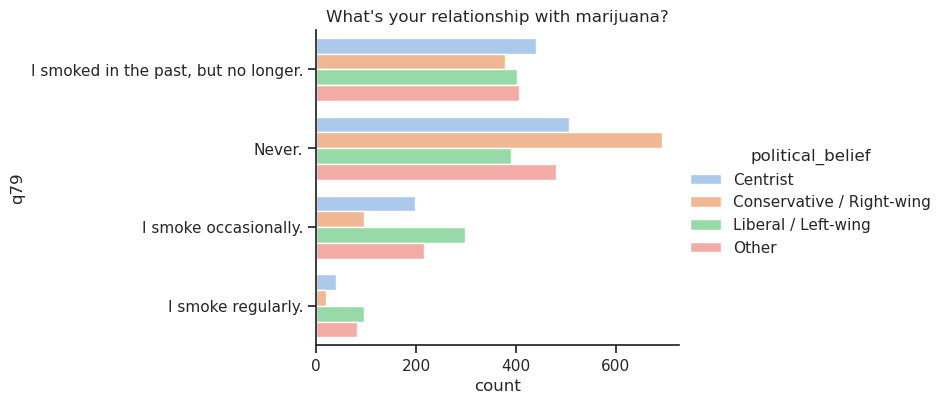

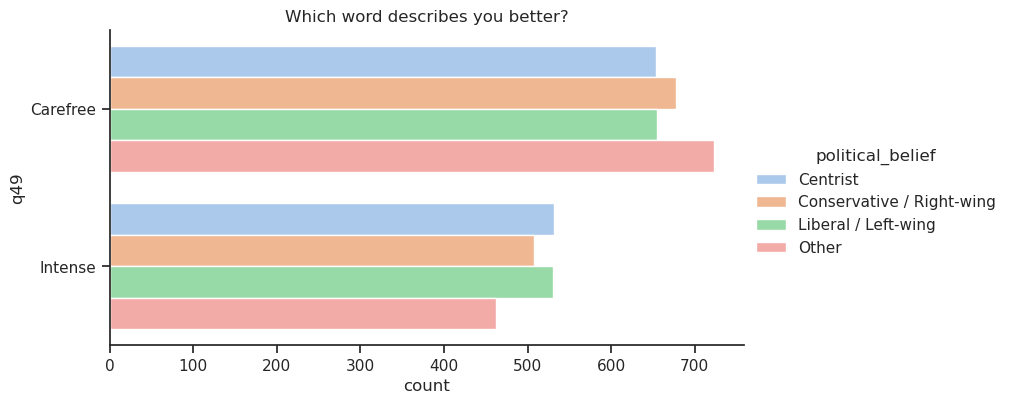

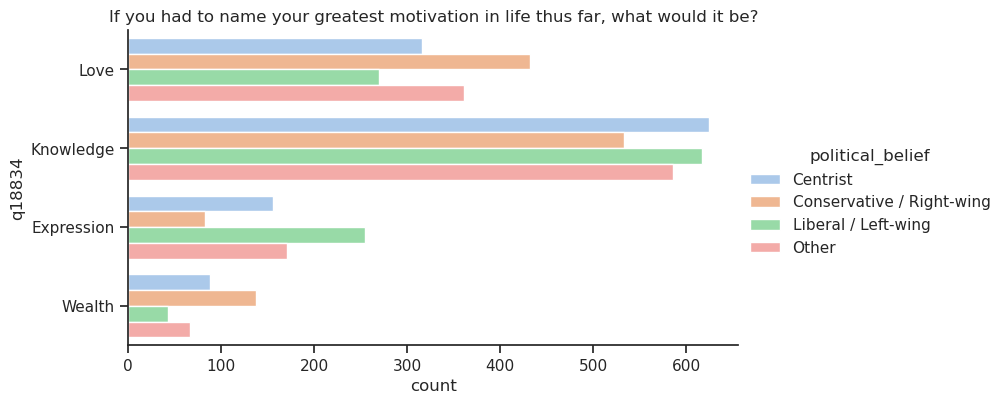

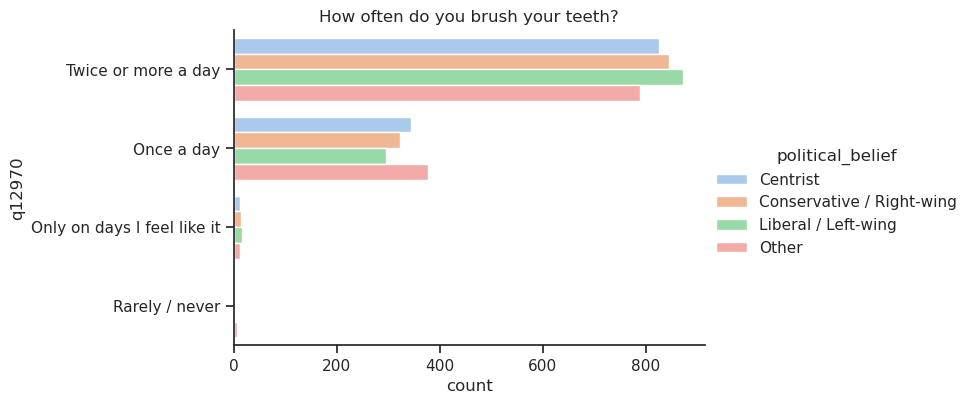

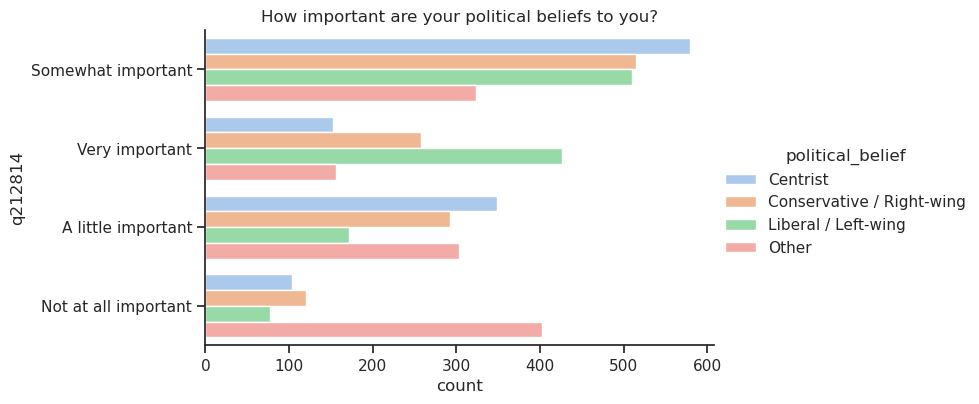

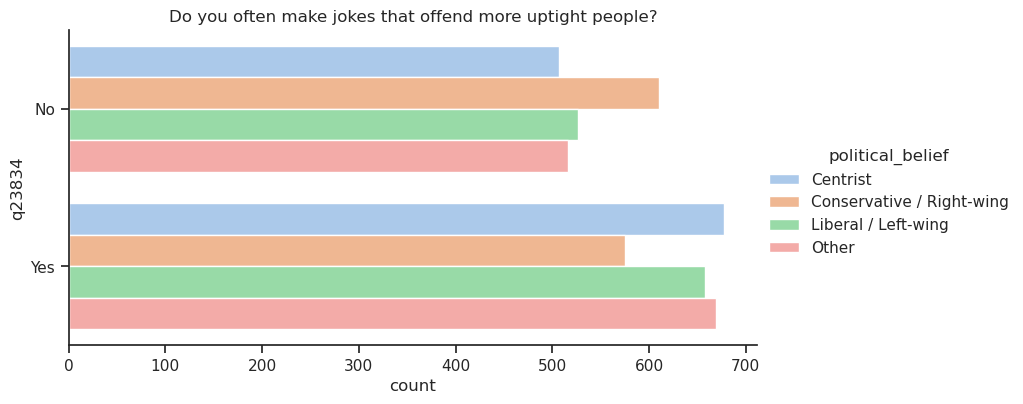

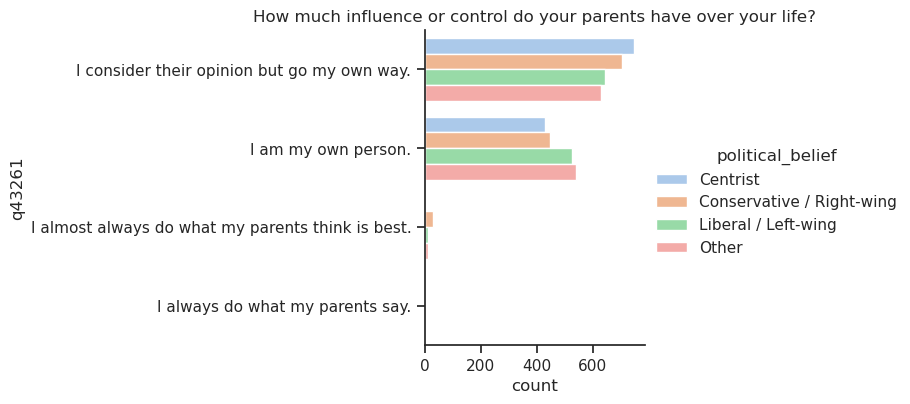

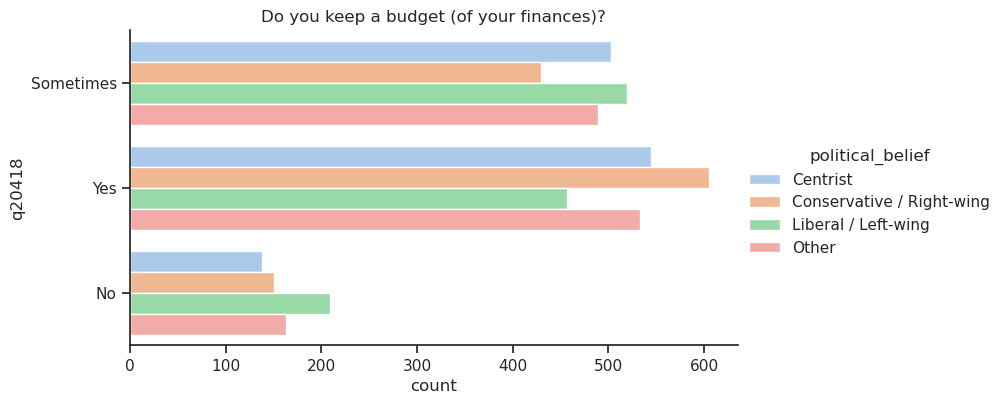

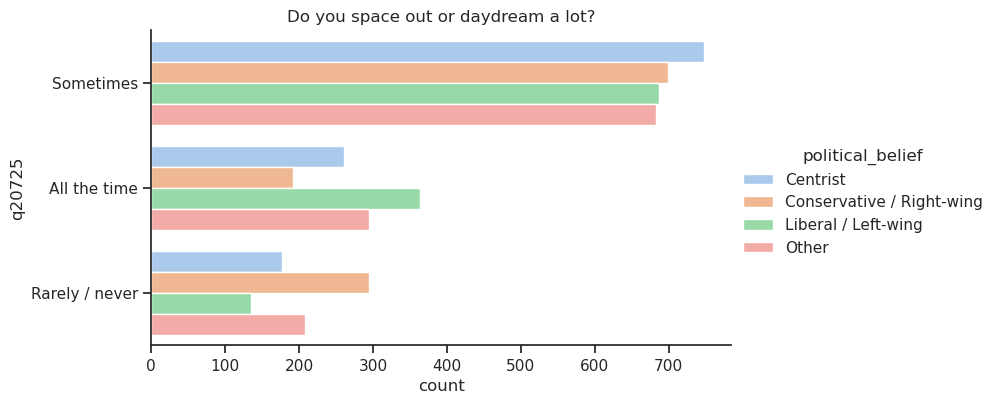

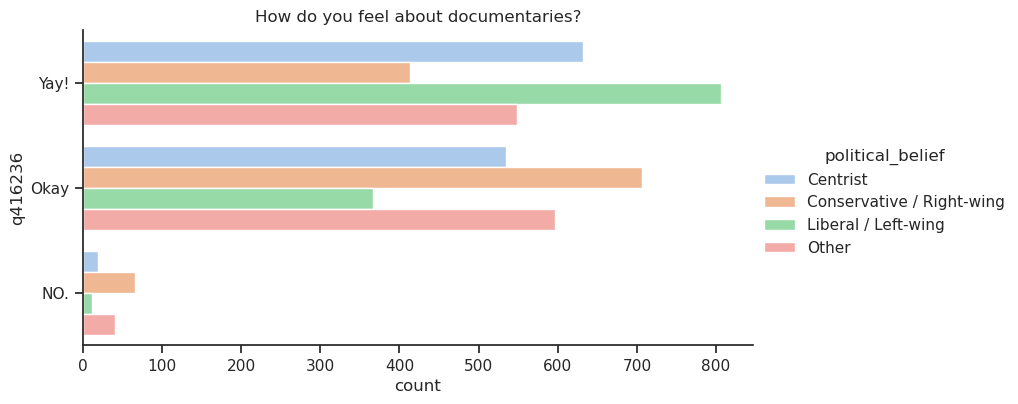

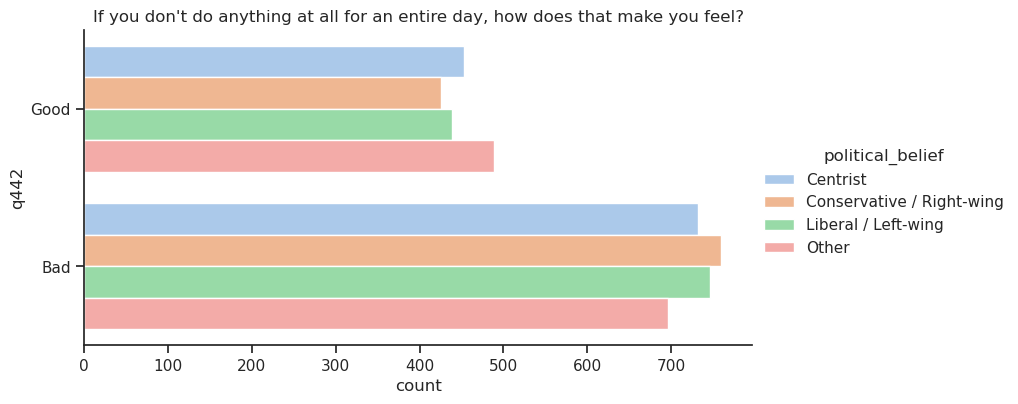

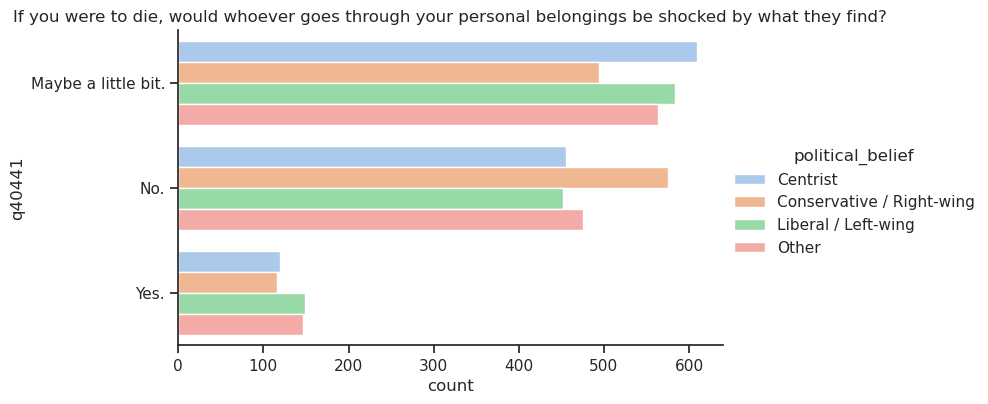

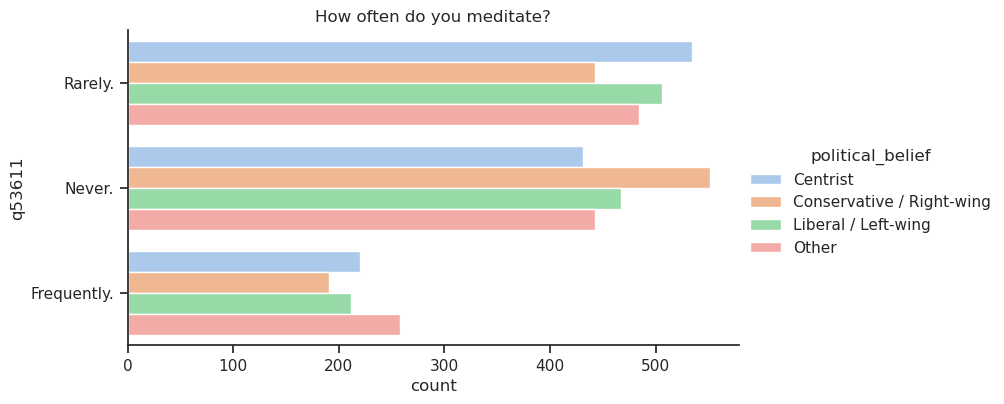

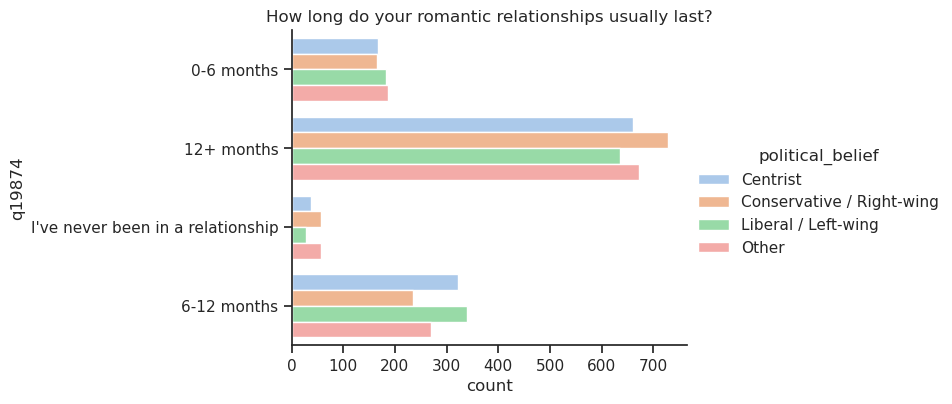

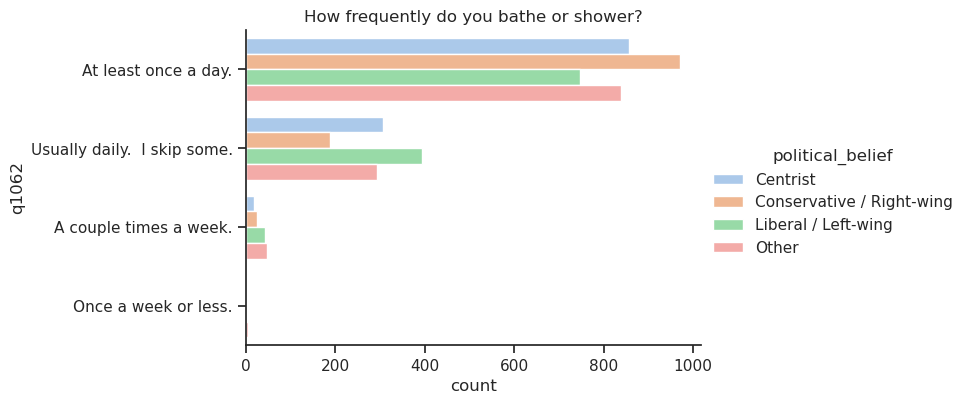

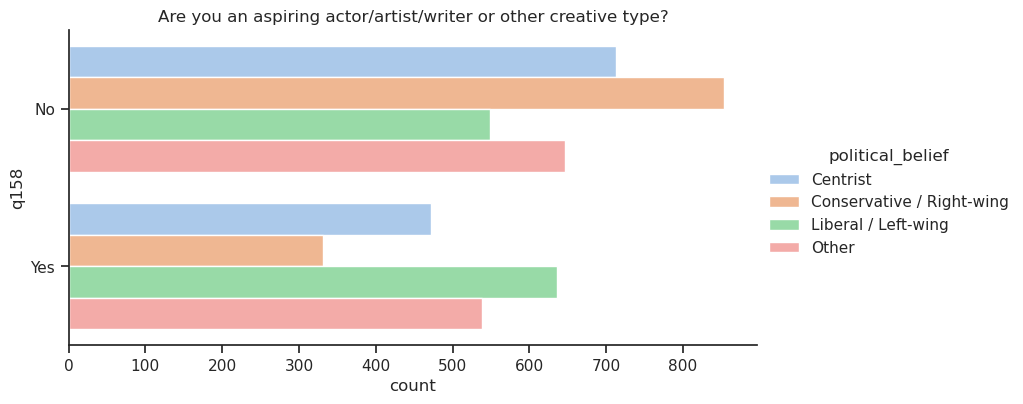

In [60]:
def plot_question_distribution(question: str, data: pd.DataFrame, questions: pd.DataFrame):
    """plots histogram of polical orientation for a given question"""
    title = questions.loc[question, 'text']
    sns.catplot(
        data=data, y=question, kind="count", hue='political_belief', palette="pastel", aspect=2, height = 4).set(title=title)

for question in top_questions:
    plot_question_distribution(question, stratified_df, questions)

# Feature Encoding und Selection

In [61]:
# split into features and target
features_df = stratified_df[top_questions]
target = stratified_df.loc[features_df.index][['political_belief']]

In [62]:
# X_train, X_val, y_train, y_val = train_test_split(features_df, target, test_size=0.15, random_state=1)
# X_train.shape, X_val.shape
# feature_encoder = OneHotEncoder()
# target_encoder = OneHotEncoder()
# X_train_encoded = feature_encoder.fit_transform(X_train)
# y_train_encoded = target_encoder.fit_transform(y_train)
# X_val_encoded = feature_encoder.fit(X_val)
# y_val_encoded = feature_encoder.fit(y_val)

In [63]:
feature_encoder = OrdinalEncoder()
target_encoder = LabelEncoder()
X_train_encoded = feature_encoder.fit_transform(features_df)
y_train_encoded = target_encoder.fit_transform(target.values.ravel())

In [64]:
fs = SelectKBest(score_func=chi2, k=12)
fs.fit(X_train_encoded, y_train_encoded)
X_train_best_feat = fs.transform(X_train_encoded)
display(X_train_best_feat.shape)
fs.scores_.shape
selected_questions = np.argpartition(fs.scores_, 0)[0:]
selected_questions = selected_questions[np.argsort(fs.scores_[selected_questions])][::-1]
 

(4740, 12)

Feature 0: How important are your political beliefs to you?: 213.95860971080148
Feature 1: What's your relationship with marijuana?: 130.59216494845538
Feature 2: How often do you keep your promises?: 119.04879282012547
Feature 3: Are you an aspiring actor/artist/writer or other creative type?: 99.44916540212576
Feature 4: If you had to name your greatest motivation in life thus far, what would it be?: 89.70476812540942
Feature 5: Do you like watching foreign movies with subtitles?: 82.19097678493321
Feature 6: How do you feel about documentaries?: 60.204340996716496
Feature 7: Have you smoked a cigarette in the last 6 months?: 48.887671232877366
Feature 8: How frequently do you bathe or shower?: 45.73768613974861
Feature 9: Rate your self-confidence:: 19.01392757660193
Feature 10: How often are you open with your feelings?: 18.653849860268153
Feature 11: How frequently do you drink alcohol?: 18.551590767311538
Feature 12: Do you keep a budget (of your finances)?: 15.05370638366317
Fea

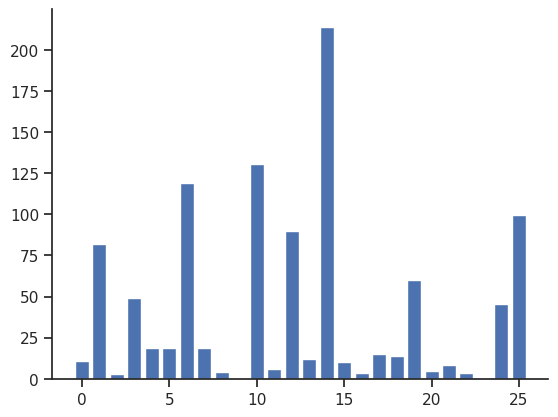

In [65]:
for i, score in enumerate(fs.scores_[selected_questions]):
    print(f'Feature {i}: {questions.loc[sorted_questions[selected_questions[i]]].text}: {score}')

# plot the scores
plt.bar(range(len(fs.scores_)), fs.scores_)
sns.despine()
plt.show()

# Model Selection

In [66]:
# Naive Bayes Hyper parameter Tuning
parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
nb = CategoricalNB(fit_prior=False)
clf = GridSearchCV(nb, parameters, scoring='accuracy', cv=5)  # stratified per default
clf.fit(X_train_best_feat, y_train_encoded)
sorted(clf.cv_results_.keys())
print('mean test score', clf.cv_results_['mean_test_score'])
print('best estimator', clf.best_estimator_)

mean test score [0.44831224 0.44831224 0.44810127 0.4478903  0.44704641 0.44092827
 0.41687764]
best estimator CategoricalNB(alpha=0.001, fit_prior=False)


In [67]:
# Logistic Regression
# one hot encoding for Logistic Regression 
feature_encoder = OneHotEncoder()
X_train_best_feat_1hot = feature_encoder.fit_transform(X_train_best_feat)
print(X_train_best_feat_1hot.shape)

(4740, 42)


In [68]:
parameters = {'C': [0.001, 0.01, 1, 10, 100]}
logreg = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=42)
clf = GridSearchCV(logreg, parameters, scoring='balanced_accuracy', cv=5)  # stratified per default
clf.fit(X_train_best_feat_1hot, y_train_encoded)
sorted(clf.cv_results_.keys())
print('mean test score', clf.cv_results_['mean_test_score'])
print('best estimator', clf.best_estimator_)


mean test score [0.43565401 0.45       0.45590717 0.4556962  0.45548523]
best estimator LogisticRegression(C=1, class_weight='balanced', max_iter=1000, random_state=42)


In [ ]:
parameters = { 
    'n_estimators': [50, 500],
    'min_samples_leaf' : [0.1, 5, 10],
}

# Fitting Random Forest Classification to the Training set
rf = RandomForestClassifier(criterion='entropy', random_state=42, class_weight='balanced')
clf = GridSearchCV(rf, parameters, scoring='balanced_accuracy', cv=5)  # stratified per default
clf.fit(X_train_best_feat_1hot, y_train_encoded)
sorted(clf.cv_results_.keys())
print('mean test score', clf.cv_results_['mean_test_score'])
print('best estimator', clf.best_estimator_)

# Evaluation

In [111]:
# Naive Bayes
clf = CategoricalNB(fit_prior=False)
y_pred = cross_val_predict(clf, X_train_best_feat, y_train_encoded, cv=10)
conf_mat = confusion_matrix(y_train_encoded, y_pred)
crossval_accuracy = accuracy_score(y_train_encoded, y_pred)
f1_score = f1_score(y_train_encoded, y_pred, average='weighted')
recall_score = recall_score(y_train_encoded, y_pred, average='weighted')
print('crossval accuracy', crossval_accuracy)
print('f1 ', f1_score)
print('recall ', recall_score)
print(conf_mat)


crossval accuracy 0.3752034725990233
f1  0.36165498623542586
recall  0.3752034725990233
[[ 518  650  453  222]
 [ 346 1020  225  252]
 [ 355  413  869  206]
 [ 320  660  504  359]]


### To-Dos:
- Data Distribution 
- Cross Validation for the 3 best model configurations
- Compute Confustion Matrix and other evaluations
- Decide which classifier to use
- Significance test
- Random features: scramble targets --> significance test

### Questions for Auguste:
- One-hot passt?
- Reicht balanced bei model? -> nicht features angepasst
- Signifance test?

# Data Distributions

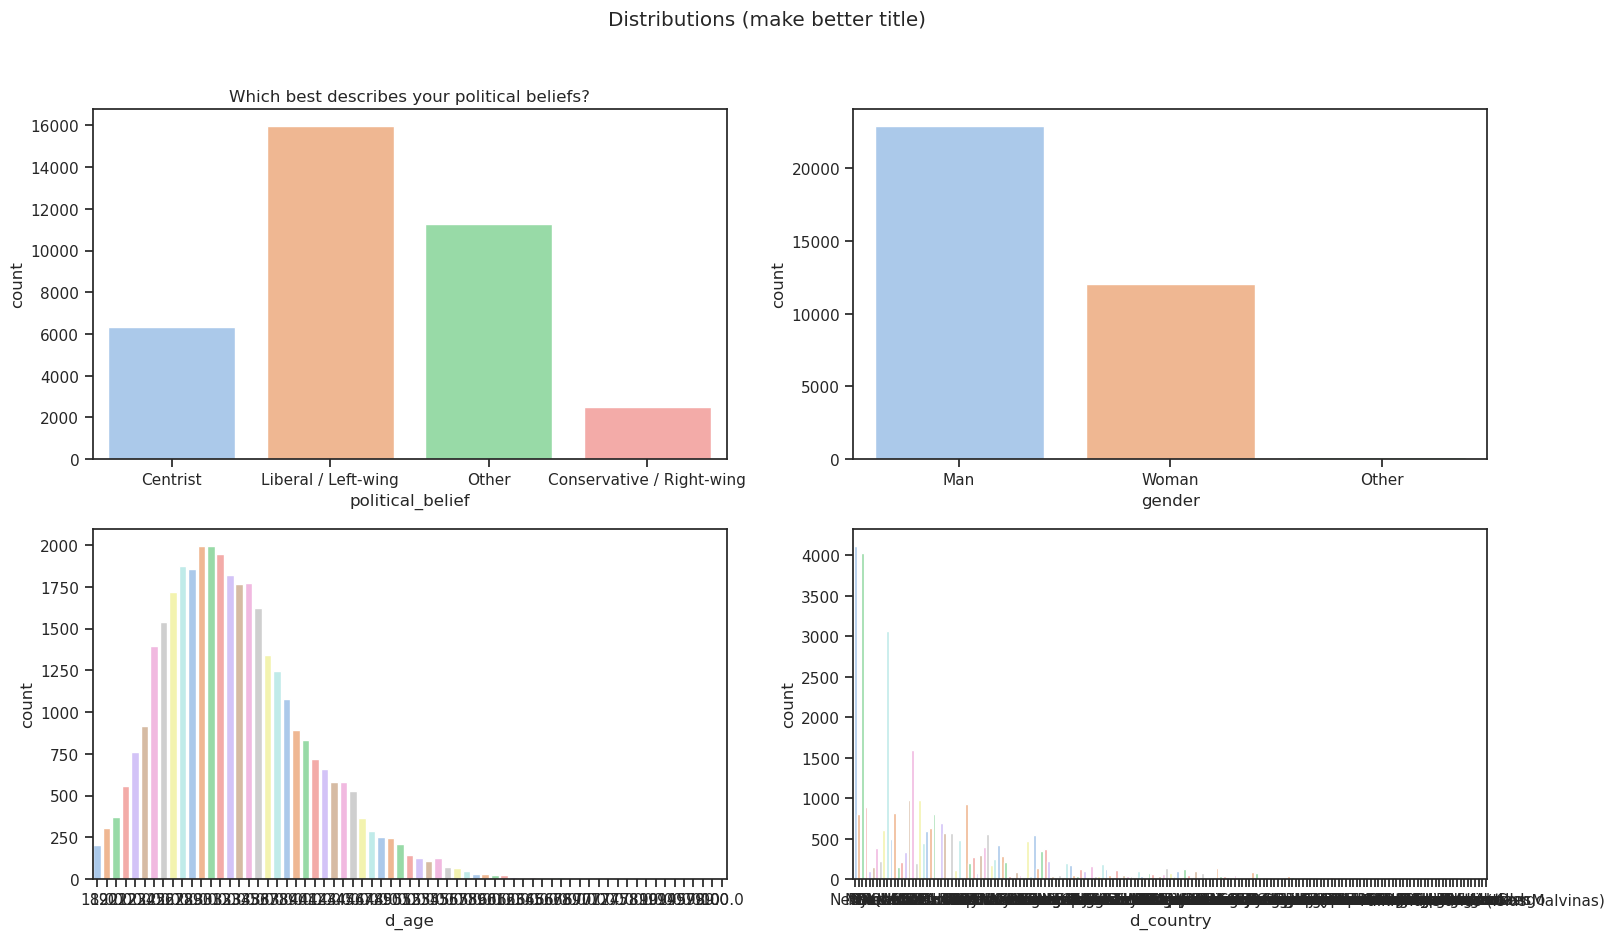

In [112]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
 
fig.suptitle('Distributions (make better title)')

 
sns.countplot(ax=axes[0, 0], data=data, x='political_belief', palette="pastel").set(title=questions.loc['q212813', 'text'])
sns.countplot(ax=axes[0, 1], data=data, x='gender', palette="pastel")
sns.countplot(ax=axes[1, 0], data=data, x='d_age', palette="pastel")
sns.countplot(ax=axes[1, 1], data=data, x='d_country', palette="pastel")
plt.show()

In [ ]:
descriptive_questions = [column for column in data.columns if column.startswith('q')]
data['n_q_answered'] = data[descriptive_questions].count(axis=1)

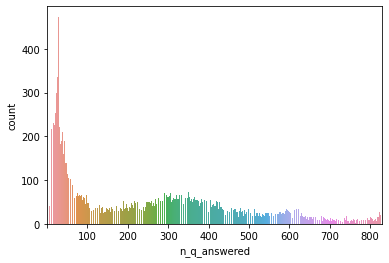

In [ ]:
ax = sns.countplot(x=data['n_q_answered'])
ax.set_xticks(range(-2, data['n_q_answered'].max(), 100))
plt.show()